In [154]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score


In [155]:
data_path = "data/html/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to USE IT AS A KEY later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:19<00:00,  6.57it/s]


In [156]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"])

[{'role': 'user',
  'text': 'Load a CSV file into a Pandas in Python. The file is named '
          "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
          "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
          "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
          "'Health Metrics'. \n"},
 {'role': 'assistant',
  'text': 'You can load a CSV file into a Pandas DataFrame in Python using the '
          "pandas.read_csv() function. Here's how you can do it for your "
          'specific CSV file:pythonCopy codeimport pandas as pd\n'
          '\n'
          '# Specify the file path\n'
          "file_path = 'cs412_hw1_dataset.csv'\n"
          '\n'
          '# Load the CSV file into a Pandas DataFrame\n'
          'df = pd.read_csv(file_path)\n'
          '\n'
          '# Display the first few rows of the DataFrame to verify the data '
          'has been loaded\n'
          'print(df.head())\n'
          "This code assume

In [157]:
#Takes a text as an input and divides it into code,text,commentCode
#by following a similar pattern used in ChatGPT responses that include code example.

def distinguisher(response):
    index=response.find(":pythonCopy code")
    index2=response.rfind("\n")
    
    if(index!=-1):
        text_part = response[:index]+ response[index2:]

        code_part = response[index + len(":pythonCopy code"):index2].strip()
        # Split the code into statements using '\n' as the delimiter
        code_part= code_part.split('\n')

        # Group statements based on whether they start with '#'
        comment_code = [s for s in code_part if s.startswith('#') and s!=""]
        actual_code = [s for s in code_part if not s.startswith('#')and s!=""]
        
        return{"text":text_part,"code":" ".join(actual_code), "commentCode": " ".join(comment_code) }
        
    else:
        #that means the response does not include a code

        text_part = response

        code_part = ""
        
    return {"text": text_part, "code": "", "commentCode":""}
        
    

In [158]:
#Takes the dictionary formatted in the same way as the dictionary provided to us initially
#and categorizes the output of ChatGPT as text, code ,commentCode

def divideTextAndCode(code2convos):
    for key, dictionaries in code2convos.items():
        
        # Iterate over the list of dictionaries for each key
        for dictionary in dictionaries:
            # Check if the role is "assistant"
            if dictionary["role"] == "assistant":
                # Apply the distinguisher function to the "text" field
                distinguished_parts = distinguisher(dictionary["text"])
                # Update the message dictionary with the modified "text" and "code" fields
                dictionary["text"]=distinguished_parts["text"]
                dictionary["code"]=distinguished_parts["code"]
                dictionary["commentCode"]=distinguished_parts["commentCode"]
                
    

In [159]:
divideTextAndCode(code2convos)

In [160]:
code2convos["41b82427-7ae2-4c55-b8a3-310bb4abada0"]

[{'role': 'user',
  'text': 'Read the .csv file with the pandas library can you do that'},
 {'role': 'assistant',
  'text': 'Certainly! To read a CSV file using the pandas library in Python, you can use the read_csv function. Make sure you have the pandas library installed before running the code. You can install it using:bashCopy codepip install pandas\nNow, assuming you have a CSV file named "your_file.csv", here\'s an example code to read it using pandas\nThis code assumes that the CSV file is in the same directory as your Python script or Jupyter Notebook. If the file is in a different directory, you should provide the full path or a relative path from your current working directory.You can customize the read_csv function with various parameters based on your specific CSV file format. For example, you can specify the delimiter, header presence, column names, etc. Refer to the pandas documentation for more details on the available options.',
  'code': "import pandas as pd file_path 

#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [161]:
#prompts -> butun promptlar tek listede
#code2prompts -> keyler html adlari , value olarak da o htmldeki promptların listesi


prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts    
    

In [162]:
code2prompts["6312a21b-c6be-44f9-ad81-46307b339fb6"]

['Give an example of how to plot a heat map of a specific results with "matplotlib"',
 'How to select a subset of features that are likely strong predictors, justifying them based on calculated correlations',
 'How to use isnull()',
 'How to do dataset comparison',
 'How to separate the dependent variable X from the independent variable y',
 'How to split training and testing sets by 80% and 20% respectively',
 'How to calculate correlations of all features in a dataset',
 'How to select a subset of features that are likely strong predictors, justifying them based on correlations',
 'How to choose the best hypermeter?',
 'How to apply hypermeter',
 'training of hypermeters',
 'How can I visualize the trained tree?']

In [163]:
def extract_user_code_comments(data):
    user_code_dict = {}
    user_comment_dict = {}

    for key, values in data.items():
        for item in values:
            if item['role'] == 'assistant':
                user_code_dict[key] = item.get('code', '')
                user_comment_dict[key] = item.get('commentCode', '')

    return user_code_dict, user_comment_dict

# Example usage
code_dict, comment_dict = extract_user_code_comments(code2convos)


# QUESTIONS MODIFIED( point indicators etc. omitted

In [164]:
questions = [
    """
First make a copy of the notebook given to you as a starter.
Make sure you choose Connect form upper right.
You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset Read the .csv file with the pandas library
""",
#####################
"""
Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
Display variable names (both dependent and independent).
Display the summary of the dataset. (Hint: You can use the **info** function)
Display the first 5 rows from training dataset. (Hint: You can use the **head** function)


Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data

Shuffle the dataset.
Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""

Correlations of features with health 
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.


Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.


Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.


""",
#####################
"""
Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen
Re-train model with the hyperparameters you have chosen 
Plot the tree you have trained
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set
Predict the labels of testing data using the tree you have trained
Report the classification accuracy.
Plot & investigate the confusion matrix. Fill the following blanks. 
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split""",
#####################
]

# CALCULATING SIMILARITY FUNCTION

In [165]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [166]:

def calculate_similarity(prompt, questions):

    # Encode prompt and questions
    prompt_embedding = model.encode(prompt, convert_to_tensor=True)
    question_embeddings = model.encode(questions, convert_to_tensor=True)

    # Calculate cosine similarity
    cosine_scores = util.pytorch_cos_sim(prompt_embedding, question_embeddings)

    # Convert the tensor to a list of similarity scores
    similarity_scores = cosine_scores.tolist()[0]

    return similarity_scores



# CREATING BASE DICTIONARY IN THE SPECIFIED FORMAT

#### Result dict contains {"htmlfilename": [ [sim1,sim2,....sim9],[sim1,sim2,....sim9],[sim1,sim2,....sim9] .... ]


In [167]:
#Result dict contains {"htmlfilename": [ [sim1,sim2,....sim9],[sim1,sim2,....sim9],[sim1,sim2,....sim9] .... ]

result_dict = {}

html_file_names = list(code2prompts.keys())

for html_file in html_file_names:
    prompts = code2prompts[html_file]
    prompt_similarities = []

    # Calculate similarity for each prompt and each question
    for prompt in prompts:
        similarity_scores = calculate_similarity(prompt, questions)
        prompt_similarities.append(similarity_scores)

    result_dict[html_file] = prompt_similarities
    



## BELOW FILES ARE BROKEN. THEY GIVE 404 ERROR

In [169]:
# BELOW FILES ARE CORRUPTED
problems = []
for key,value in code2prompts.items():
    if len(code2prompts[key])==0:
        print(key)
        problems.append(key)

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


# TAKING MAXIMUM SIMILARITY FOR EACH QUESTION AMONG ALL PROMPTS FOR A SINGLE FILE

#### IF FILE IS BROKEN, WE GIVE ALL 0 TO SIMILARITIES BETWEEN QUESTIONS


In [17]:

#TAKING MAXIMUM SIMILARITY FOR EACH QUESTION AMONG ALL PROMPTS FOR A SINGLE FILE

#test_dict = {"html_file_1": [[0.1,0.2,0.1,0.1,0.1,0.1,0.1,0.1,0.1],[0.4,0.9,0.3,0.1,0.1,0.1,0.1,0.1,0.1]],
 #              "html_file_2": []}

new_result_dict = {}

for html_file, prompt_list in result_dict.items():
    if not prompt_list:
        continue
        # If the prompt list is empty, WE ARE NOT ADDING ITS SIMILARITY
        #new_result_dict[html_file] = [0.0] * 9
    else:
        # Pad the prompt_list with zeros if the number of questions is less than 9
        prompt_list += [[0.0] * 9] * (9 - len(prompt_list))
        # Calculate the maximum similarity for each question across all prompts
        max_sims = [max(prompt_list[i][j] for i in range(len(prompt_list))) for j in range(9)]
        new_result_dict[html_file] = max_sims
        
        
        
# Convert the related_questions_dict to a DataFrame
df_prompt_matching = pd.DataFrame.from_dict(new_result_dict, orient='index')

# Set column names as 'Q0', 'Q1', ..., 'Q8'
df_prompt_matching.columns = [f'Q{i}' for i in range(df_prompt_matching.shape[1])]

# Reset the index to make 'HTML_File' a column
df_prompt_matching.reset_index(inplace=True)
df_prompt_matching.rename(columns={'index': 'HTML_File'}, inplace=True)

# Assuming df is your DataFrame
df_prompt_matching.set_index('HTML_File', inplace=True)

# Display the DataFrame
df_prompt_matching.head(5)

,Q0,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
HTML_File,,,,,,,,,
0031c86e-81f4-4eef-9e0e-28037abf9883,0.242323,0.650829,0.639897,0.790341,0.690072,0.788218,0.428342,0.461473,0.285456
0225686d-b825-4cac-8691-3a3a5343df2b,0.412892,0.822821,0.696175,0.909993,0.766649,0.987573,0.684214,0.729532,0.491343
041f950b-c013-409a-a642-cffff60b9d4b,0.173714,0.217742,0.274107,0.284707,0.487476,0.249203,0.297617,0.538953,0.142434
04f91058-d0f8-4324-83b2-19c671f433dc,0.285610,0.548311,0.439191,0.645035,0.770841,0.659323,0.553139,0.538424,0.426416
089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.444721,0.758592,0.872447,0.712805,0.821277,0.916046,0.555504,0.945931,0.590542


# TO HAVE AVERAGE SIMILARITY VALUES 

### i.e we are taking average between all sim1's sim2's among all prompts for a single prompt


In [170]:
## TO HAVE AVERAGE SIMILARITY VALUES 

avg_result_dict = {}



# Calculate the average similarity for each question across all prompts
for html_file, similarities_list in result_dict.items():
    num_prompts = len(similarities_list)
    num_questions = len(similarities_list[0]) if num_prompts > 0 else 0

    if num_prompts > 0:
        avg_similarities = [sum(similarities_list[j][i] for j in range(num_prompts)) / num_prompts for i in range(num_questions)]
    else:
        avg_similarities = [0] * num_questions

    avg_result_dict[html_file] = avg_similarities
    

    
# Convert the dictionary to a DataFrame if needed
df_avg_matching = pd.DataFrame.from_dict(avg_result_dict, orient='index', columns=[f'Q{i}' for i in range(len(avg_similarities))])

# Reset the index to make 'HTML_File' a column
df_avg_matching.reset_index(inplace=True)
df_avg_matching.rename(columns={'index': 'HTML_File'}, inplace=True)


# Assuming df is your DataFrame
df_avg_matching.set_index('HTML_File', inplace=True)

# Display the DataFrame
df_avg_matching.head()


,Q0,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
HTML_File,,,,,,,,,
0031c86e-81f4-4eef-9e0e-28037abf9883,0.131876,0.285558,0.380305,0.294066,0.365903,0.294589,0.238968,0.332627,0.124415
0225686d-b825-4cac-8691-3a3a5343df2b,0.122576,0.273231,0.337141,0.305693,0.296665,0.323831,0.312685,0.376181,0.209524
041f950b-c013-409a-a642-cffff60b9d4b,0.010530,0.111217,0.168907,0.115451,0.081844,0.124755,0.130175,0.235636,0.061148
04f91058-d0f8-4324-83b2-19c671f433dc,0.075920,0.184396,0.277807,0.223789,0.240406,0.197946,0.239033,0.298362,0.167645
089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.069941,0.156857,0.249157,0.239491,0.215537,0.198821,0.210744,0.289835,0.165927


# TO HAVE YES OR NO TYPE OF MODEL

### FOR A SINGLE FILE WE LOOK AT ALL sim1's among all the prompts, we identify the highest one and put a yes for corresponding question

In [171]:
## TO HAVE YES OR NO TYPE OF MODEL



# Function to get the index of the maximum value in a list
def get_max_index(lst):
    return max(range(len(lst)), key=lst.__getitem__, default=None)

# Create a new dictionary to store related questions for each HTML file
yes_no_dict = {}

for html_file, similarities_list in result_dict.items():
    
    # Get the index of the question with the highest similarity for each prompt
    related_questions = [get_max_index(prompt) for prompt in similarities_list]

    # Create a list indicating whether each question is related (Yes) or not (No)
    is_related = ['Yes' if i in related_questions else 'No' for i in range(len(similarities_list[0]))] if similarities_list else ['No'] * 9

    yes_no_dict[html_file] = is_related

# Convert the related_questions_dict to a DataFrame
df_yes_no = pd.DataFrame.from_dict(yes_no_dict, orient='index')

# Set column names as 'Q0', 'Q1', ..., 'Q8'
df_yes_no.columns = [f'Q{i}' for i in range(df_yes_no.shape[1])]

# Reset the index to make 'HTML_File' a column
df_yes_no.reset_index(inplace=True)
df_yes_no.rename(columns={'index': 'HTML_File'}, inplace=True)

# Assuming df is your DataFrame
df_yes_no.set_index('HTML_File', inplace=True)

# Display the DataFrame
df_yes_no.head(5)

,Q0,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
HTML_File,,,,,,,,,
0031c86e-81f4-4eef-9e0e-28037abf9883,No,Yes,Yes,Yes,Yes,Yes,No,Yes,No
0225686d-b825-4cac-8691-3a3a5343df2b,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
041f950b-c013-409a-a642-cffff60b9d4b,No,Yes,No,No,Yes,No,Yes,Yes,No
04f91058-d0f8-4324-83b2-19c671f433dc,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
089eb66d-4c3a-4f58-b98f-a3774a2efb34,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [172]:
import re

def calculate_discomfort_count(text):
    # Discomfort indicators
    discomfort_keywords = ["no", "not really", "confused", "error","not correct"
                       "disappointed", "frustrated", "annoyed", "doesn't work", "apologize", "does not work",
                       "didn't work", "did not work", "wrong","didnt work","doesnt work","didnt understand",
                           "did not understand", "didn't understand"
                       "assertionerror", "attributeerror", "eoferror", "floatingpointerror",
                       "generatorexit", "importerror", "indexerror", "keyerror", "keyboardinterrupt",
                       "memoryerror", "nameerror", "notimplementederror", "oserror", "overflowerror",
                       "referenceerror", "runtimeerror", "stopiteration", "syntaxerror",
                       "indentationerror", "taberror", "systemerror", "systemexit", "typeerror",
                       "unboundlocalerror", "unicodeerror", "unicodeencodeerror", "unicodedecodeerror",
                       "unicodetranslateerror", "valueerror", "zerodivisionerror"]


    # Count the number of discomfort indicators in the text
    discomfort_count = sum(1 for keyword in discomfort_keywords if re.search(rf'\b{re.escape(keyword)}\b', text.lower(), flags=re.IGNORECASE))


    return discomfort_count




In [173]:
def calculate_comfort_count(text):
    # Comfort indicators
    comfort_keywords = ["good", "great", "awesome", "satisfied", "happy", "well done", "thank you", "excellent","thanks","worked",
                       "works","well"]

    # Count the number of comfort indicators in the text
    comfort_count = sum(1 for keyword in comfort_keywords if re.search(rf'\b{re.escape(keyword)}\b', text.lower(), flags=re.IGNORECASE))

    return comfort_count

In [174]:
def calculate_gpt_confusion(text):
    confusion_keywords=["apologize","confusion","misunderstanding","misunderstood","apologies","oversight"]
    confusion_count = sum(1 for keyword in confusion_keywords if re.search(rf'\b{re.escape(keyword)}\b', text.lower(), flags=re.IGNORECASE))

    return confusion_count

In [175]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def sim_between_prompt_and_commentcode(user_message,gpt_code_comment):

    message_embedding = model.encode(user_message, convert_to_tensor=True)
    gpt_commentcode_embedding = model.encode(gpt_code_comment, convert_to_tensor=True)



    # Calculate cosine similarity
    cosine_scores = util.pytorch_cos_sim(message_embedding, gpt_commentcode_embedding)

    # Convert the tensor to a list of similarity scores
    similarity_scores = cosine_scores.tolist()[0]

    return similarity_scores[0]

# BELOW FUNCTION USES WORD2VEC MODEL AND CALCULATES THE SIMILARITY AMONG ALL PROMPTS

### used for identifying how similar the prompts are

In [176]:
import gensim.downloader
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
# Load the GloVe model
model_name = "glove-wiki-gigaword-100"
word_to_vec = gensim.downloader.load(model_name)

In [177]:
def calculate_average_cosine_similarity(user_prompts, word_to_vec):
    if len(user_prompts) < 2:
        # if there is only one user prompt then there is not one more prompt to compare with
        return 0.0

    # Vectorize each user prompt
    prompt_vectors = [vectorize(prompt) for prompt in user_prompts]

    # Calculate cosine similarity matrix
    similarity_matrix = cosine_similarity(prompt_vectors)

    # Exclude the diagonal elements (self-similarity)
    similarity_matrix_no_diagonal = similarity_matrix - np.eye(len(similarity_matrix))

    # Calculate the average similarity
    average_similarity = similarity_matrix_no_diagonal.sum() / (len(user_prompts) * (len(user_prompts) - 1))

    return average_similarity


In [178]:

def vectorize(prompt):
    words = prompt.lower().split()  # tokenizing
    
    # put zero vector if there is no representation in word_to_vec.
    word_vectors = [word_to_vec[word] if word in word_to_vec else np.zeros_like(word_to_vec['word'])
                    for word in words]  
    # take average of all. 
    # by averaging the size is fixed for all reviews,
    # the size is equal to the size of an encoding of a single word in word_to_vec
    average_vector = np.mean(word_vectors, axis=0)
    return average_vector






In [179]:
def calculate_word_count(text):
    # Split the text into words using a regular expression
    words = re.findall(r'\b\w+\b', text)
    return len(words)



# BY USING THE ABOVE FUNCTIONS AND MODELS, WE ARE STARTING TO CREATE OUR DATAFRAME WITH IDENTIFIED FEATURES

In [209]:
code2features = defaultdict(lambda : defaultdict(int))


for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    user_prompts = []
    similarities_prompt_commentCode=[]
    for c in convs:
        # iterating over each dictionary
        # {"role": "user", "text": }, {"role": "assistant", "text":, "code":, "commentCode": }
        
        lastCommentCode=""
        if c["role"]=="assistant":
            
            lastCommentCode=c["commentCode"]
                
                
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts
            user_prompts.append(text)

            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            code2features[code]["total_discomfort_count"] += calculate_discomfort_count(text)
            code2features[code]["total_comfort_count"] += calculate_comfort_count(text)
            code2features[code]["prompt_avg_words"] += calculate_word_count(text)
            
            
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_words"] += calculate_word_count(text)
            #Response confusion metric
            code2features[code]["response_confusion_total_count"]+=calculate_gpt_confusion(text)
            if lastCommentCode!="":
                
                similarities_prompt_commentCode.append(sim_between_prompt_and_commentcode(prevText,lastCommentCode))   
            
        prevText=text

    code2features[code]["prompt_avg_words"] /= code2features[code]["#user_prompts"]
    code2features[code]["response_avg_words"] /= code2features[code]["#user_prompts"]
    average_similarity = calculate_average_cosine_similarity(user_prompts, word_to_vec)
    code2features[code]["similarity_between_prompts"] = average_similarity
    
    if len(similarities_prompt_commentCode) > 0:
        code2features[code]["avg_sim_between_prompt_codeComment"] = sum(similarities_prompt_commentCode) / len(similarities_prompt_commentCode)
    else:
        code2features[code]["avg_sim_between_prompt_codeComment"] = 0  
    
        

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [210]:
df = pd.DataFrame(code2features).T

In [211]:
df

,#user_prompts,total_discomfort_count,total_comfort_count,prompt_avg_words,response_avg_words,response_confusion_total_count,similarity_between_prompts,avg_sim_between_prompt_codeComment
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,8.0,0.0,63.071429,160.642857,2.0,0.959773,0.558252
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,39.666667,169.166667,1.0,0.913921,0.556858
041f950b-c013-409a-a642-cffff60b9d4b,9.0,8.0,1.0,99.111111,160.444444,12.0,0.802151,0.331554
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,3.0,0.0,17.750000,148.500000,3.0,0.904731,0.419597
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,16.0,1.0,30.697674,123.000000,19.0,0.889234,0.470122
...,...,...,...,...,...,...,...,...
f24219d6-07f0-4baf-80ac-18475dc5b66f,21.0,1.0,0.0,31.380952,202.666667,5.0,0.883792,0.377319
f2f18684-4a16-4c05-a2d1-c0f96d1de869,71.0,3.0,2.0,48.211268,200.408451,17.0,0.884943,0.482037
f852596d-fdca-45aa-9050-d4f76ce6a53c,30.0,6.0,1.0,93.766667,116.266667,4.0,0.919986,0.492801
f8ec3336-fd48-4654-ad98-62ccfb96d096,14.0,0.0,1.0,77.000000,272.142857,1.0,0.903643,0.398174


# ADDING 1 MORE FEATURE --- CREATING AVERAGE VECTOR OF THE ONES WHO GET 100, AND PUTTING SIMILARITY FUNCTION

In [212]:
htmls_100_scores = ["ba18e4e8-2c26-46d4-ba31-cc21947aabd5",
"58bee29c-a749-463e-8d56-c4edf0815b3f",
"51f35201-da77-4b6d-a455-99cc84195c5c",
"223ae726-cb25-49df-a125-c4af3519c8e8",
"e264c424-a241-43f7-acca-9fbbf21dc1c6",
"f2f18684-4a16-4c05-a2d1-c0f96d1de869",
"c21be348-17bd-4fdd-88f5-137f6a13cdee",
"c91d6fef-baf5-4e77-8bfc-b14fb7fc770d",
"58fcd378-aa29-4067-813c-bb4de525428e",
"5a62a8ee-c67c-475e-bd85-cf6d83c90ea9",
"089eb66d-4c3a-4f58-b98f-a3774a2efb34",
"f8ec3336-fd48-4654-ad98-62ccfb96d096",
"36bab6e3-0d16-4626-846b-33c0384f0c79",
"5541316f-6fbd-4441-b513-ac252e6355ec",
"97f57cf9-4f02-4f8c-b65c-8ea0009a82a2",
"7b0ecddc-caa5-4b81-88ea-cd65a7270900",
"17bd62e7-6792-4399-a573-07456a73901b",
"26d95379-e2f1-454c-a9d2-60cd80bc06a5",
"745bb746-6467-4146-8ef5-55f3ee3f589e",
"1b54e38b-3b1d-425e-835a-d1e0fb2694fc",
"27de4332-d81f-47a2-b2a9-c0b023a30919",
"1038cb22-8ad2-4030-b44a-59f10352e91c",
]

# Initialize an empty dictionary to aggregate the features
aggregated_features_100 = defaultdict(float)

# Initialize a counter for the number of files that scored 100
count_files_score_100 = 0

# Iterate through each HTML file that scored 100 and aggregate their features
for code in htmls_100_scores:
    if code in code2features:
        count_files_score_100 += 1
        for feature in df.columns.tolist():
            aggregated_features_100[feature] += code2features[code].get(feature, 0)

average_features_100 = {feature: total / count_files_score_100 for feature, total in aggregated_features_100.items()}

vector_list = list(average_features_100.values())


def calculate_similarity(row):
    row_values = row.values.tolist()
    similarity = cosine_similarity([vector_list], [row_values])
    return similarity[0][0]


df['similarity_between_fullpoints'] = df.apply(calculate_similarity, axis=1)



In [213]:
df.head()

,#user_prompts,total_discomfort_count,total_comfort_count,prompt_avg_words,response_avg_words,response_confusion_total_count,similarity_between_prompts,avg_sim_between_prompt_codeComment,similarity_between_fullpoints
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,8.0,0.0,63.071429,160.642857,2.0,0.959773,0.558252,0.984955
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,39.666667,169.166667,1.0,0.913921,0.556858,0.988546
041f950b-c013-409a-a642-cffff60b9d4b,9.0,8.0,1.0,99.111111,160.444444,12.0,0.802151,0.331554,0.950704
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,3.0,0.0,17.750000,148.500000,3.0,0.904731,0.419597,0.980123
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,16.0,1.0,30.697674,123.000000,19.0,0.889234,0.470122,0.928597


# ADDING NEW FEATURES. LET'S ADD METRICS THAT MEASURE HOW DETAİLED THE PROMPTS ARE


In [214]:
import string
from collections import Counter

def analyze_messages(user_id, messages):
    total_message_length = sum(len(message) for message in messages)
    average_message_length = total_message_length / len(messages) if len(messages) > 0 else 0

    all_text = " ".join(messages)
    words = all_text.split()

    total_word_count = len(words)
    average_word_count_per_sentence = total_word_count / len(messages) if len(messages) > 0 else 0

    average_word_length = sum(len(word) for word in words) / total_word_count if total_word_count > 0 else 0

    english_conjunctions_count = sum(1 for word in words if word.lower() in {"and", "or", "but", "so", "yet"})

    example_words_count = sum(1 for word in words if word.lower() in {"example", "illustrate", "demonstrate"})

    total_parentheses_count = sum(message.count('(') + message.count(')') for message in messages)

    prompt_num = len(messages)

    return {
        "total_message_length": total_message_length, #EKLE
        
        "average_word_count_per_sentence": average_word_count_per_sentence, #EKLE
        "average_word_length": average_word_length, #EKLE
        "english_conjunctions_count": english_conjunctions_count, #EKLE
        "example_words_count": example_words_count, #EKLE
        "total_parentheses_count": total_parentheses_count #EKLE
    }

user_analyses = {user_id: analyze_messages(user_id, messages) for user_id, messages in code2prompts.items()}

# Sonuçları yazdırma
for user_id, analysis in user_analyses.items():
    print(f"Analiz Sonuçları - {user_id}:\n{analysis}\n{'='*30}")

Analiz Sonuçları - 0031c86e-81f4-4eef-9e0e-28037abf9883:
{'total_message_length': 5701, 'average_word_count_per_sentence': 63.07142857142857, 'average_word_length': 5.438278595696489, 'english_conjunctions_count': 32, 'example_words_count': 2, 'total_parentheses_count': 14}
Analiz Sonuçları - 0225686d-b825-4cac-8691-3a3a5343df2b:
{'total_message_length': 4700, 'average_word_count_per_sentence': 39.388888888888886, 'average_word_length': 5.423131170662906, 'english_conjunctions_count': 10, 'example_words_count': 0, 'total_parentheses_count': 65}
Analiz Sonuçları - 041f950b-c013-409a-a642-cffff60b9d4b:
{'total_message_length': 5967, 'average_word_count_per_sentence': 97.55555555555556, 'average_word_length': 5.619589977220957, 'english_conjunctions_count': 13, 'example_words_count': 0, 'total_parentheses_count': 100}
Analiz Sonuçları - 04f91058-d0f8-4324-83b2-19c671f433dc:
{'total_message_length': 2282, 'average_word_count_per_sentence': 17.75, 'average_word_length': 5.087323943661972, '

In [215]:
user_analyses

{'0031c86e-81f4-4eef-9e0e-28037abf9883': {'total_message_length': 5701,
  'average_word_count_per_sentence': 63.07142857142857,
  'average_word_length': 5.438278595696489,
  'english_conjunctions_count': 32,
  'example_words_count': 2,
  'total_parentheses_count': 14},
 '0225686d-b825-4cac-8691-3a3a5343df2b': {'total_message_length': 4700,
  'average_word_count_per_sentence': 39.388888888888886,
  'average_word_length': 5.423131170662906,
  'english_conjunctions_count': 10,
  'example_words_count': 0,
  'total_parentheses_count': 65},
 '041f950b-c013-409a-a642-cffff60b9d4b': {'total_message_length': 5967,
  'average_word_count_per_sentence': 97.55555555555556,
  'average_word_length': 5.619589977220957,
  'english_conjunctions_count': 13,
  'example_words_count': 0,
  'total_parentheses_count': 100},
 '04f91058-d0f8-4324-83b2-19c671f433dc': {'total_message_length': 2282,
  'average_word_count_per_sentence': 17.75,
  'average_word_length': 5.087323943661972,
  'english_conjunctions_coun

In [216]:
new_features_df = pd.DataFrame.from_dict(user_analyses, orient='index')

# Step 2: Merge the two DataFrames based on the index (html file codes)
df = df.merge(new_features_df, left_index=True, right_index=True)

# RIGHT NOW THIS DF DOES NOT INCLUDE THE BROKEN FILES

In [217]:
df

,#user_prompts,total_discomfort_count,total_comfort_count,prompt_avg_words,response_avg_words,response_confusion_total_count,similarity_between_prompts,avg_sim_between_prompt_codeComment,similarity_between_fullpoints,total_message_length,average_word_count_per_sentence,average_word_length,english_conjunctions_count,example_words_count,total_parentheses_count
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,8.0,0.0,63.071429,160.642857,2.0,0.959773,0.558252,0.984955,5701,63.071429,5.438279,32,2,14
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,39.666667,169.166667,1.0,0.913921,0.556858,0.988546,4700,39.388889,5.423131,10,0,65
041f950b-c013-409a-a642-cffff60b9d4b,9.0,8.0,1.0,99.111111,160.444444,12.0,0.802151,0.331554,0.950704,5967,97.555556,5.619590,13,0,100
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,3.0,0.0,17.750000,148.500000,3.0,0.904731,0.419597,0.980123,2282,17.750000,5.087324,6,0,12
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,16.0,1.0,30.697674,123.000000,19.0,0.889234,0.470122,0.928597,18669,28.767442,6.212207,59,2,271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f24219d6-07f0-4baf-80ac-18475dc5b66f,21.0,1.0,0.0,31.380952,202.666667,5.0,0.883792,0.377319,0.981626,4035,30.857143,5.219136,9,1,69
f2f18684-4a16-4c05-a2d1-c0f96d1de869,71.0,3.0,2.0,48.211268,200.408451,17.0,0.884943,0.482037,0.992739,23006,41.760563,6.075211,34,1,192
f852596d-fdca-45aa-9050-d4f76ce6a53c,30.0,6.0,1.0,93.766667,116.266667,4.0,0.919986,0.492801,0.929497,21776,84.433333,7.281879,31,0,307
f8ec3336-fd48-4654-ad98-62ccfb96d096,14.0,0.0,1.0,77.000000,272.142857,1.0,0.903643,0.398174,0.982006,7143,69.857143,5.768916,10,0,78


# FINALIZE YOUR DATAFRAME AND CONCATANATE WITH SCORES

### AFTER THAT START CREATING YOUR MODEL

# OUR SCORES

In [218]:
# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


# OUR PROMPT MATCHING

### OUR PROMPT MATCHING DOES NOT INCLUDE THE BROKEN FILES.

In [219]:
df_prompt_matching

,Q0,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
HTML_File,,,,,,,,,
0031c86e-81f4-4eef-9e0e-28037abf9883,0.242323,0.650829,0.639897,0.790341,0.690072,0.788218,0.428342,0.461473,0.285456
0225686d-b825-4cac-8691-3a3a5343df2b,0.412892,0.822821,0.696175,0.909993,0.766649,0.987573,0.684214,0.729532,0.491343
041f950b-c013-409a-a642-cffff60b9d4b,0.173714,0.217742,0.274107,0.284707,0.487476,0.249203,0.297617,0.538953,0.142434
04f91058-d0f8-4324-83b2-19c671f433dc,0.285610,0.548311,0.439191,0.645035,0.770841,0.659323,0.553139,0.538424,0.426416
089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.444721,0.758592,0.872447,0.712805,0.821277,0.916046,0.555504,0.945931,0.590542
...,...,...,...,...,...,...,...,...,...
f24219d6-07f0-4baf-80ac-18475dc5b66f,0.302987,0.418350,0.546734,0.490407,0.466607,0.502019,0.941213,0.928735,0.771037
f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.311383,0.368891,0.549631,0.966176,0.655741,0.945437,0.608420,0.934719,0.769781
f852596d-fdca-45aa-9050-d4f76ce6a53c,0.435313,0.975701,0.889675,0.977834,0.903663,0.947942,0.807891,0.956091,0.427795


# MERGE BETWEEN
## DATAFRAME WITH FEATURES & DATAFRAME WITH PROMPT MATCHING

In [220]:
df = df.merge(df_prompt_matching, left_index=True, right_index=True)

In [221]:
df

,#user_prompts,total_discomfort_count,total_comfort_count,prompt_avg_words,response_avg_words,response_confusion_total_count,similarity_between_prompts,avg_sim_between_prompt_codeComment,similarity_between_fullpoints,total_message_length,...,total_parentheses_count,Q0,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,8.0,0.0,63.071429,160.642857,2.0,0.959773,0.558252,0.984955,5701,...,14,0.242323,0.650829,0.639897,0.790341,0.690072,0.788218,0.428342,0.461473,0.285456
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,39.666667,169.166667,1.0,0.913921,0.556858,0.988546,4700,...,65,0.412892,0.822821,0.696175,0.909993,0.766649,0.987573,0.684214,0.729532,0.491343
041f950b-c013-409a-a642-cffff60b9d4b,9.0,8.0,1.0,99.111111,160.444444,12.0,0.802151,0.331554,0.950704,5967,...,100,0.173714,0.217742,0.274107,0.284707,0.487476,0.249203,0.297617,0.538953,0.142434
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,3.0,0.0,17.750000,148.500000,3.0,0.904731,0.419597,0.980123,2282,...,12,0.285610,0.548311,0.439191,0.645035,0.770841,0.659323,0.553139,0.538424,0.426416
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,16.0,1.0,30.697674,123.000000,19.0,0.889234,0.470122,0.928597,18669,...,271,0.444721,0.758592,0.872447,0.712805,0.821277,0.916046,0.555504,0.945931,0.590542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f24219d6-07f0-4baf-80ac-18475dc5b66f,21.0,1.0,0.0,31.380952,202.666667,5.0,0.883792,0.377319,0.981626,4035,...,69,0.302987,0.418350,0.546734,0.490407,0.466607,0.502019,0.941213,0.928735,0.771037
f2f18684-4a16-4c05-a2d1-c0f96d1de869,71.0,3.0,2.0,48.211268,200.408451,17.0,0.884943,0.482037,0.992739,23006,...,192,0.311383,0.368891,0.549631,0.966176,0.655741,0.945437,0.608420,0.934719,0.769781
f852596d-fdca-45aa-9050-d4f76ce6a53c,30.0,6.0,1.0,93.766667,116.266667,4.0,0.919986,0.492801,0.929497,21776,...,307,0.435313,0.975701,0.889675,0.977834,0.903663,0.947942,0.807891,0.956091,0.427795
f8ec3336-fd48-4654-ad98-62ccfb96d096,14.0,0.0,1.0,77.000000,272.142857,1.0,0.903643,0.398174,0.982006,7143,...,78,0.431563,0.993305,0.853336,0.678769,0.851377,0.906791,0.930366,0.918092,0.630520


# ADDING BROKEN FILE'S INDEXES, WE USE THE AVERAGE VALUE IN THE DATAFRAME IN ORDER TO PERFORM DATA IMPUTATION

In [222]:
# New indexes
new_indexes = ['139235c7-736c-4237-92f0-92e8c116832c',
               '668ad17e-0240-49f7-b5a7-d22e502554c6',
               'b0640e51-6879-40cb-a4f5-329f952ef99d',
               'da6b70d5-29f6-491a-ad46-037c77067128']

# Create a new DataFrame with the new indexes
new_rows_df = pd.DataFrame(index=new_indexes, columns=df.columns)

# Calculate averages for each column and set them for the new indexes
for column in df.columns:
    avg_value = df[column].mean()
    new_rows_df[column] = avg_value

# Concatenate the original DataFrame with the new rows DataFrame
df = pd.concat([df, new_rows_df])

In [223]:
df['#user_prompts'] = df['#user_prompts'].astype(int)
df['total_discomfort_count'] = df['total_discomfort_count'].astype(int)
df['total_comfort_count'] = df['total_comfort_count'].astype(int)
df['response_confusion_total_count'] = df['response_confusion_total_count'].astype(int)
df['total_message_length'] = df['total_message_length'].astype(int)
df['total_parentheses_count'] = df['total_parentheses_count'].astype(int)
df['english_conjunctions_count'] = df['english_conjunctions_count'].astype(int)
df['example_words_count'] = df['example_words_count'].astype(int)



# THE DATAFRAME TO ADD THE SCORE INFO LATER.

In [224]:
df

,#user_prompts,total_discomfort_count,total_comfort_count,prompt_avg_words,response_avg_words,response_confusion_total_count,similarity_between_prompts,avg_sim_between_prompt_codeComment,similarity_between_fullpoints,total_message_length,...,total_parentheses_count,Q0,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
0031c86e-81f4-4eef-9e0e-28037abf9883,14,8,0,63.071429,160.642857,2,0.959773,0.558252,0.984955,5701,...,14,0.242323,0.650829,0.639897,0.790341,0.690072,0.788218,0.428342,0.461473,0.285456
0225686d-b825-4cac-8691-3a3a5343df2b,18,0,0,39.666667,169.166667,1,0.913921,0.556858,0.988546,4700,...,65,0.412892,0.822821,0.696175,0.909993,0.766649,0.987573,0.684214,0.729532,0.491343
041f950b-c013-409a-a642-cffff60b9d4b,9,8,1,99.111111,160.444444,12,0.802151,0.331554,0.950704,5967,...,100,0.173714,0.217742,0.274107,0.284707,0.487476,0.249203,0.297617,0.538953,0.142434
04f91058-d0f8-4324-83b2-19c671f433dc,20,3,0,17.750000,148.500000,3,0.904731,0.419597,0.980123,2282,...,12,0.285610,0.548311,0.439191,0.645035,0.770841,0.659323,0.553139,0.538424,0.426416
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86,16,1,30.697674,123.000000,19,0.889234,0.470122,0.928597,18669,...,271,0.444721,0.758592,0.872447,0.712805,0.821277,0.916046,0.555504,0.945931,0.590542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fb8de815-224c-4d06-9fd4-7156d1a9920d,31,16,2,50.806452,114.548387,3,0.902465,0.427945,0.988390,11417,...,199,0.449902,0.904886,0.830096,0.879708,0.849048,0.970448,0.930143,0.919492,0.619326
139235c7-736c-4237-92f0-92e8c116832c,28,4,0,48.153147,150.265901,6,0.862682,0.449188,0.969126,10170,...,130,0.338774,0.568363,0.637507,0.717978,0.749788,0.760652,0.672611,0.723560,0.533915
668ad17e-0240-49f7-b5a7-d22e502554c6,28,4,0,48.153147,150.265901,6,0.862682,0.449188,0.969126,10170,...,130,0.338774,0.568363,0.637507,0.717978,0.749788,0.760652,0.672611,0.723560,0.533915
b0640e51-6879-40cb-a4f5-329f952ef99d,28,4,0,48.153147,150.265901,6,0.862682,0.449188,0.969126,10170,...,130,0.338774,0.568363,0.637507,0.717978,0.749788,0.760652,0.672611,0.723560,0.533915


# GRADE DISTRIBUTIONS

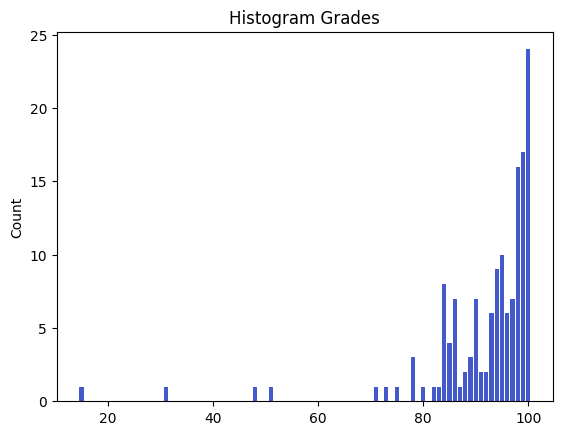

In [225]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

# UNSETTING THE INDEXES AS HTML FILE NAMES

In [226]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df

,code,#user_prompts,total_discomfort_count,total_comfort_count,prompt_avg_words,response_avg_words,response_confusion_total_count,similarity_between_prompts,avg_sim_between_prompt_codeComment,similarity_between_fullpoints,...,total_parentheses_count,Q0,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14,8,0,63.071429,160.642857,2,0.959773,0.558252,0.984955,...,14,0.242323,0.650829,0.639897,0.790341,0.690072,0.788218,0.428342,0.461473,0.285456
1,0225686d-b825-4cac-8691-3a3a5343df2b,18,0,0,39.666667,169.166667,1,0.913921,0.556858,0.988546,...,65,0.412892,0.822821,0.696175,0.909993,0.766649,0.987573,0.684214,0.729532,0.491343
2,041f950b-c013-409a-a642-cffff60b9d4b,9,8,1,99.111111,160.444444,12,0.802151,0.331554,0.950704,...,100,0.173714,0.217742,0.274107,0.284707,0.487476,0.249203,0.297617,0.538953,0.142434
3,04f91058-d0f8-4324-83b2-19c671f433dc,20,3,0,17.750000,148.500000,3,0.904731,0.419597,0.980123,...,12,0.285610,0.548311,0.439191,0.645035,0.770841,0.659323,0.553139,0.538424,0.426416
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86,16,1,30.697674,123.000000,19,0.889234,0.470122,0.928597,...,271,0.444721,0.758592,0.872447,0.712805,0.821277,0.916046,0.555504,0.945931,0.590542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,fb8de815-224c-4d06-9fd4-7156d1a9920d,31,16,2,50.806452,114.548387,3,0.902465,0.427945,0.988390,...,199,0.449902,0.904886,0.830096,0.879708,0.849048,0.970448,0.930143,0.919492,0.619326
123,139235c7-736c-4237-92f0-92e8c116832c,28,4,0,48.153147,150.265901,6,0.862682,0.449188,0.969126,...,130,0.338774,0.568363,0.637507,0.717978,0.749788,0.760652,0.672611,0.723560,0.533915
124,668ad17e-0240-49f7-b5a7-d22e502554c6,28,4,0,48.153147,150.265901,6,0.862682,0.449188,0.969126,...,130,0.338774,0.568363,0.637507,0.717978,0.749788,0.760652,0.672611,0.723560,0.533915
125,b0640e51-6879-40cb-a4f5-329f952ef99d,28,4,0,48.153147,150.265901,6,0.862682,0.449188,0.969126,...,130,0.338774,0.568363,0.637507,0.717978,0.749788,0.760652,0.672611,0.723560,0.533915


# Merging scores with features

# IT IS THE FINAL DATAFRAME WE HAVE IN ORDER TO START ANALYZING OUR DATA, MODIFYING SOME COLUMNS, DEVELOPING OUR MODEL

In [237]:
final_df = pd.merge(df, scores, on='code', how="left")


# One data point is not having grade, so it is being dropped.

In [239]:
nan_values = final_df.isna().sum()

# Display the count of NaN values for each column
print("NaN values in each column:")
print(nan_values)
final_df = final_df.dropna(subset=['grade'])

nan_values = final_df.isna().sum()

# Display the count of NaN values for each column
print("NaN values in each column AFTER DROP:")
print(nan_values)

NaN values in each column:
code                                  0
#user_prompts                         0
total_discomfort_count                0
total_comfort_count                   0
prompt_avg_words                      0
response_avg_words                    0
response_confusion_total_count        0
similarity_between_prompts            0
avg_sim_between_prompt_codeComment    0
similarity_between_fullpoints         0
total_message_length                  0
average_word_count_per_sentence       0
average_word_length                   0
english_conjunctions_count            0
example_words_count                   0
total_parentheses_count               0
Q0                                    0
Q1                                    0
Q2                                    0
Q3                                    0
Q4                                    0
Q5                                    0
Q6                                    0
Q7                                    0
Q8           

In [242]:
final_df

,code,#user_prompts,total_discomfort_count,total_comfort_count,prompt_avg_words,response_avg_words,response_confusion_total_count,similarity_between_prompts,avg_sim_between_prompt_codeComment,similarity_between_fullpoints,...,Q0,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14,8,0,63.071429,160.642857,2,0.959773,0.558252,0.984955,...,0.242323,0.650829,0.639897,0.790341,0.690072,0.788218,0.428342,0.461473,0.285456,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18,0,0,39.666667,169.166667,1,0.913921,0.556858,0.988546,...,0.412892,0.822821,0.696175,0.909993,0.766649,0.987573,0.684214,0.729532,0.491343,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9,8,1,99.111111,160.444444,12,0.802151,0.331554,0.950704,...,0.173714,0.217742,0.274107,0.284707,0.487476,0.249203,0.297617,0.538953,0.142434,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20,3,0,17.750000,148.500000,3,0.904731,0.419597,0.980123,...,0.285610,0.548311,0.439191,0.645035,0.770841,0.659323,0.553139,0.538424,0.426416,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86,16,1,30.697674,123.000000,19,0.889234,0.470122,0.928597,...,0.444721,0.758592,0.872447,0.712805,0.821277,0.916046,0.555504,0.945931,0.590542,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,fb8de815-224c-4d06-9fd4-7156d1a9920d,31,16,2,50.806452,114.548387,3,0.902465,0.427945,0.988390,...,0.449902,0.904886,0.830096,0.879708,0.849048,0.970448,0.930143,0.919492,0.619326,98.0
141,139235c7-736c-4237-92f0-92e8c116832c,28,4,0,48.153147,150.265901,6,0.862682,0.449188,0.969126,...,0.338774,0.568363,0.637507,0.717978,0.749788,0.760652,0.672611,0.723560,0.533915,86.0
142,668ad17e-0240-49f7-b5a7-d22e502554c6,28,4,0,48.153147,150.265901,6,0.862682,0.449188,0.969126,...,0.338774,0.568363,0.637507,0.717978,0.749788,0.760652,0.672611,0.723560,0.533915,99.0
143,b0640e51-6879-40cb-a4f5-329f952ef99d,28,4,0,48.153147,150.265901,6,0.862682,0.449188,0.969126,...,0.338774,0.568363,0.637507,0.717978,0.749788,0.760652,0.672611,0.723560,0.533915,98.0


# LAST CHAPTER- DO YOUR MODIFICATIONS ON THE DATASET, AND START DEVELOPING YOUR MODEL

# YOUR DATAFRAME VARIABLE NAME IS -> final_df

In [274]:
final_df["avg_discomfort_count_per_prompt"]=final_df["total_discomfort_count"]/final_df["#user_prompts"]
final_df["avg_comfort_count_per_prompt"]=final_df["total_comfort_count"]/final_df["#user_prompts"]
final_df["avg_example_words_count_per_prompt"]=final_df["example_words_count"]/final_df["#user_prompts"]
final_df["avg_parentheses_count_per_prompt"]=final_df["total_parentheses_count"]/final_df["#user_prompts"]
final_df["avg_english_conjunctions_count_per_prompts"]=final_df["english_conjunctions_count"]/final_df["#user_prompts"]


In [275]:
final_df.shape

(144, 31)

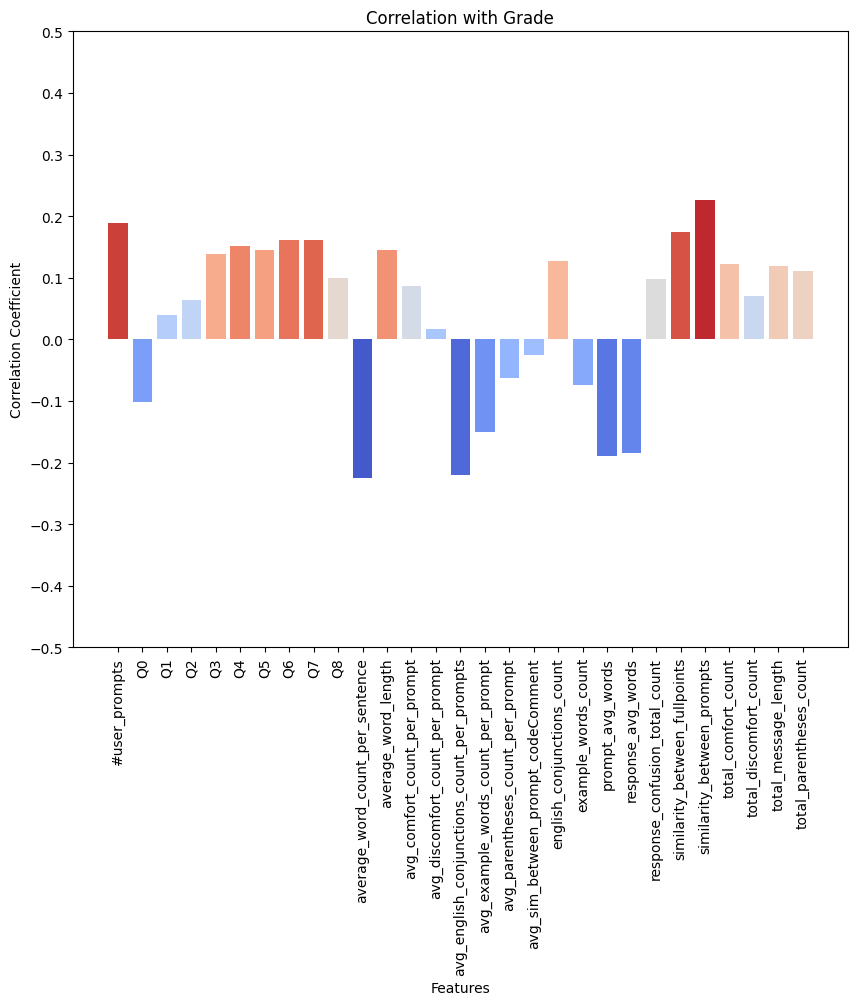

In [276]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude 'code' column
columns_to_exclude = ['code']

# Get columns for correlation (excluding 'code' and only considering 'grade')
columns_for_correlation = final_df.columns.difference(columns_to_exclude + ['grade'])

# Create a correlation matrix for selected columns with 'grade'
correlation_matrix = final_df[columns_for_correlation].corrwith(final_df['grade'])

# Visualize the correlations with 'grade' using a bar plot
plt.figure(figsize=(10, 8))

colors = sns.color_palette("coolwarm", n_colors=len(correlation_matrix))
color_mapping = dict(zip(sorted(correlation_matrix.unique()), colors))

# Map correlation values to colors
correlation_colors = correlation_matrix.map(color_mapping)




plt.bar(correlation_matrix.index, correlation_matrix.values, color=correlation_colors)
plt.title('Correlation with Grade')
plt.xlabel('Features')
# Set y-axis ticks for both the upper and lower parts
plt.yticks(np.arange(-1.0, 1.1, 0.1))
plt.ylim(-0.5, 0.5)
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.show()

# NOW ITS TIME FOR FEATURE ELIMINATION 

In [280]:
X = final_df.drop(['grade','code'], axis=1)
y = final_df['grade']

# FEATURE SELECTION METHOD 1

In [264]:
# Set a correlation threshold (e.g., 0.2)
correlation_threshold = 0.1

# Filter out features with correlation coefficients below the threshold
significant_correlations = correlation_matrix[abs(correlation_matrix) >= correlation_threshold]

# Print out individual correlation coefficients
for feature, correlation in significant_correlations.items():
    print(f"{feature}: {correlation}")

#user_prompts: 0.18957228663377607
Q0: -0.10145357784777245
Q3: 0.1384303848172555
Q4: 0.15074335050642496
Q5: 0.1451600197712245
Q6: 0.16092375959020275
Q7: 0.16112629056957456
average_word_count_per_sentence: -0.22500066011857492
average_word_length: 0.14516339132429246
english_conjunctions_count: 0.12749372809389445
prompt_avg_words: -0.18938664374014139
response_avg_words: -0.18480741747162954
similarity_between_fullpoints: 0.17359840345838695
similarity_between_prompts: 0.2260730920855574
total_comfort_count: 0.12308744169286479
total_message_length: 0.1193450291421037
total_parentheses_count: 0.11126880810486012


# FEATURE SELECTION METHOD 2

In [269]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Assuming X and y are your feature and target datasets
model = RandomForestClassifier()
rfe = RFE(model, n_features_to_select=10)  # Adjust the number of features as needed
fit = rfe.fit(X, y)

# Selected features
selected_features = X.columns[fit.support_]
print(selected_features)

Index(['prompt_avg_words', 'response_avg_words',
       'response_confusion_total_count', 'similarity_between_fullpoints',
       'average_word_count_per_sentence', 'average_word_length', 'Q3', 'Q4',
       'Q5', 'Q8'],
      dtype='object')


# FEATURE SELECTION METHOD 3

In [268]:
from sklearn.feature_selection import mutual_info_classif

# Assuming X and y are your feature and target datasets
mutual_info_scores = mutual_info_classif(X, y, discrete_features=False)

# Select top k features based on mutual information scores
k = 10  # Adjust k as needed
selected_features = X.columns[np.argsort(mutual_info_scores)[-k:]]
print(selected_features)

Index(['similarity_between_prompts', 'Q0', 'total_comfort_count', 'Q3', 'Q2',
       'Q6', 'average_word_length', 'Q8', 'Q1',
       'response_confusion_total_count'],
      dtype='object')


#### Train/Test split

In [286]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 115
Test set size: 29


#### Fitting a model

#### Predicting and Analyzing 

In [292]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=10)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [293]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 160.70200378071786
Node 1 has MSE 110.30817174515141
Node 2 has MSE 77.8627927010748
Node 3 has MSE 60.53794642857065
Node 4 has MSE 135.97333333333245
Node 5 has MSE 114.1875
Node 6 has MSE 4.222222222222626
Node 7 has MSE 0.0
Node 8 has MSE 1.0
Node 9 has MSE 0.0
Node 10 has MSE 0.0
Node 11 has MSE 0.0
Node 12 has MSE 14.561983471076019
Node 13 has MSE 3.6875
Node 14 has MSE 1.0
Node 15 has MSE 0.0
Node 16 has MSE 0.0
Node 17 has MSE 0.25
Node 18 has MSE 0.0
Node 19 has MSE 0.0
Node 20 has MSE 6.244897959184527
Node 21 has MSE 2.1599999999998545
Node 22 has MSE 0.25
Node 23 has MSE 0.0
Node 24 has MSE 0.0
Node 25 has MSE 0.22222222222444543
Node 26 has MSE 0.0
Node 27 has MSE 0.0
Node 28 has MSE 0.0
Node 29 has MSE 38.21745137634207
Node 30 has MSE 33.303734535784315
Node 31 has MSE 30.664634146341996
Node 32 has MSE 69.66666666666606
Node 33 has MSE 36.33057851239755
Node 34 has MSE 10.693877551018886
Node 35 has MSE 3.4400000000023283
Node 36 has MSE 2.25
Node 37 has

In [58]:
# Plotting the Tree 
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("hw")

'hw.pdf'

In [59]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 8.279086892488953
MSE TEST: 101.55122448979591
R2 Train: 0.9493387005574656
R2 TEST: 0.09543774326422416


## FINALLY LETS ADD 1 MORE FEATURE ABOUT CHATGPT CODE RESPONSE

#### FROM THE GIVEN CODE ANSWERS, WE SELECT THE STUDENTS WHO RECEIVE 100 AND ARE CLOSEST TO EACH OTHER. THEN LET'S MEASURE THE SIMILAR  CODES OF EACH STUDENT TO THESE STUDENTS' CODES.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity1(code_dict):
    # Extract code values from the dictionary
    code_values = list(code_dict.values())

    # Use TfidfVectorizer to convert code values into TF-IDF vectors
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(code_values)

    # Calculate cosine similarity between the TF-IDF vectors
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # Create a dictionary to store similarities
    similarity_dict = {}
    names = list(code_dict.keys())

    # Fill the similarity dictionary
    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            pair = f"{names[i]} - {names[j]}"
            similarity_dict[pair] = similarity_matrix[i, j]

    return similarity_dict

# Example usage
similarity_dict1 = calculate_similarity1(code_dict)

# Print the similarity values
for pair, similarity in similarity_dict1.items():
    print(f"Similarity between {pair}: {similarity:.4f}")


In [71]:
top_students = scores[scores["grade"] == 100]

# Eğer birden fazla varsa, tüm öğrencilerin kodlarını bir liste olarak alabilirsiniz
top_students_codes = top_students["code"].tolist()

max_similiars = []

for pair, similarity in similarity_dict1.items():
    if similarity >= 0.1:
        #max_similiars.append(pair)
        element1, element2 = pair.split(" - ")
        if element1 in top_students_codes and element2 in top_students_codes:
            max_similiars.append(element1)
            max_similiars.append(element2)
    
max_similiars = list(set(max_similiars))

In [ ]:
average_similarities = {}

print(average_similarities)

for code in scores["code"]:
    points = []
    for best in max_similiars:
        if code != best:
            pair1 = code + " - " + best
            pair2 = best + " - " + code
            if pair1 in similarity_dict1:
                #print("p1 " + str(similarity_dict1[pair1]))
                points.append(similarity_dict1[pair1])
            elif pair2 in similarity_dict1:
                #print("p2 " + str(similarity_dict1[pair2]))
                points.append(similarity_dict1[pair2])
    if len(points) != 0:
        avg = sum(points) / len(points)
    else:
        avg = 0
        print(code)
    average_similarities[code] = avg
    

print(average_similarities)

In [ ]:
df.columns.values[0] = 'user_id'

df['code_similarity_compare2_bestgrades'] = df['new_column_name'].map(average_similarities)

print(df)

## We know that some of the data is inaccurate and problematic. Now let's fill in the missing data of these faulty people with average values ​​according to the norm range they received.

In [ ]:
# 86 puan için 88 ve 84 aralığı
# 99 puan için 98 ve 100 aralığı
# 98 puan için 97 ve 99 aralığı
# 95 puan için 94 ve 96 aralığı

recive_86 = filtered_codes = df.loc[(df['score'] >= 84) & (df['score'] <= 88), 'code'].tolist()
recive_99 = filtered_codes = df.loc[(df['score'] >= 98) & (df['score'] <= 100), 'code'].tolist()
recive_98 = filtered_codes = df.loc[(df['score'] >= 97) & (df['score'] <= 99), 'code'].tolist()
recive_95 = filtered_codes = df.loc[(df['score'] >= 94) & (df['score'] <= 95), 'code'].tolist()

averages_dict86 = {}

# Her bir kolon için ortalama değeri hesapla ve dictionary'e ekle
for column in df.columns[1:]:  # İlk sütun user_id, onu hariç tutuyoruz
    averages_dict86[column] = df[df['user_id'].isin(recive_86)][column].mean()

averages_dict99 = {}

# Her bir kolon için ortalama değeri hesapla ve dictionary'e ekle
for column in df.columns[1:]:  # İlk sütun user_id, onu hariç tutuyoruz
    averages_dict99[column] = df[df['user_id'].isin(recive_99)][column].mean()


averages_dict98 = {}

# Her bir kolon için ortalama değeri hesapla ve dictionary'e ekle
for column in df.columns[1:]:  # İlk sütun user_id, onu hariç tutuyoruz
    averages_dict98[column] = df[df['user_id'].isin(recive_98)][column].mean()

averages_dict95 = {}

# Her bir kolon için ortalama değeri hesapla ve dictionary'e ekle
for column in df.columns[1:]:  # İlk sütun user_id, onu hariç tutuyoruz
    averages_dict95[column] = df[df['user_id'].isin(recive_95)][column].mean()


def update_dataframe_with_dict(df, user_id, update_dict):
    # Belirli user_id'ye sahip olan satırı bul
    user_index = df.index[df['user_id'] == user_id].tolist()

    # Eğer user_id bulunamazsa hata mesajı yazdır
    if not user_index:
        print(f"User with user_id {user_id} not found.")
        return df

    user_index = user_index[0]

    # Her bir kolon için dictionary'den gelen değeri DataFrame'e yaz
    for column, value in update_dict.items():
        if column in df.columns:
            df.loc[user_index, column] = value

    return df


df = update_dataframe_with_dict(df, '139235c7-736c-4237-92f0-92e8c116832c', averages_dict86)

df = update_dataframe_with_dict(df, '668ad17e-0240-49f7-b5a7-d22e502554c6', averages_dict99)

df = update_dataframe_with_dict(df, 'b0640e51-6879-40cb-a4f5-329f952ef99d', averages_dict98)

df = update_dataframe_with_dict(df, 'da6b70d5-29f6-491a-ad46-037c77067128', averages_dict95)



